In [1]:
import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
import pandas as pd

import dgl
import numpy as np
import torch as th
from dgl.nn import EdgeGATConv

%matplotlib inline

#torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [3]:
df1=pd.read_csv('./dataset/ogbn_proteins/raw/edge.csv.gz')
df2=pd.read_csv('./dataset/ogbn_proteins/raw/node_species.csv.gz')
df3=pd.read_csv('./dataset/ogbn_proteins/raw/node-label-modified.csv.gz')
df4=pd.read_csv('./dataset/ogbn_proteins/raw/edge-feat.csv.gz')

In [3]:
graph = dgl.graph((df1['1'], df1['96401']))

In [7]:
graph.ndata['feature']=torch.tensor(df3.iloc[:,:].values)
graph.edata['feature']=torch.tensor(df4.iloc[:,:].values)

In [74]:
species_dict={}
for species_id in df2['3702'].unique():
    species_dict[species_id]=[]
node_id=0
for species_id in df2['3702']:
    species_dict[species_id].append(node_id)
    node_id+=1

In [81]:
selected_species=[4932,511145]
selected_nodes=[]
for species_id in selected_species:
    selected_nodes=selected_nodes+species_dict[species_id]

In [10]:
subgraph = graph.subgraph(selected_nodes)

print("Number of nodes in subgraph:", subgraph.number_of_nodes())
print("Number of edges in subgraph:", subgraph.number_of_edges())

# You can also access the adjacency matrix of the subgraph
# print("Adjacency matrix of subgraph:\n", subgraph.adjacency_matrix())

# If you have node features, you can copy them to the subgraph
if 'feature' in graph.ndata:
    subgraph.ndata['feature'] = graph.ndata['feature'][selected_nodes]

# If you have edge features, you can copy them to the subgraph
if 'feature' in graph.edata:
    src, dst = graph.all_edges()
    edge_mask = torch.tensor([(s in selected_nodes) and (d in selected_nodes) for s, d in zip(src.numpy(), dst.numpy())])
    subgraph.edata['feature'] = graph.edata['feature'][edge_mask]

# Print information about the subgraph features
if 'feature' in subgraph.ndata:
    print("Node features in subgraph:\n", subgraph.ndata['feature'])

if 'feature' in subgraph.edata:
    print("Edge features in subgraph:\n", subgraph.edata['feature'])

Number of nodes in subgraph: 10693
Number of edges in subgraph: 1458949
Node features in subgraph:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0]])
Edge features in subgraph:
 tensor([[0.5010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.5010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.5010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        ...,
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.1680],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.4510],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.1620]],
       dtype=torch.float64)


In [11]:
subgraph

Graph(num_nodes=10693, num_edges=1458949,
      ndata_schemes={'feature': Scheme(shape=(112,), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feature': Scheme(shape=(8,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [12]:
import pickle

with open('subgraph.pkl', 'wb') as file:
    pickle.dump(subgraph, file)


In [2]:
import pickle
with open('subgraph.pkl', 'rb') as file:
    subgraph = pickle.load(file)

print(subgraph.edata['feature'])


tensor([[0.5010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.5010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.5010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        ...,
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.1680],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.4510],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.1620]],
       dtype=torch.float64)


In [5]:
subgraph.edata['feature'].dtype

torch.float64

In [3]:
subgraph.ndata['feature']=subgraph.ndata['feature'].to(torch.float32)
subgraph.edata['feature']=subgraph.edata['feature'].to(torch.float32)

In [4]:
import networkx as nx
G=dgl.to_networkx(subgraph)
A=nx.to_scipy_sparse_matrix(G, format='csr')
A

<10693x10693 sparse matrix of type '<class 'numpy.intc'>'
	with 1458949 stored elements in Compressed Sparse Row format>

In [5]:
from scipy.sparse import csr_matrix
X=csr_matrix(subgraph.ndata['feature'].cpu().numpy())
X

<10693x112 sparse matrix of type '<class 'numpy.float32'>'
	with 173392 stored elements in Compressed Sparse Row format>

In [7]:
df = pd.read_csv('./dataset/ogbn_proteins/raw/node_species.csv.gz', header=None, names=['species_id'])

In [8]:
# Define the list of selected species
selected_species=[4932,511145]

# Filter the DataFrame for selected species
# Filter the DataFrame for selected species
df_selected_species = df[df['species_id'].isin(selected_species)]

# Create an affiliation matrix using pivot_table
affiliation_matrix = pd.get_dummies(df_selected_species, columns=['species_id']).groupby(level=0, axis=1).max()


C:\Users\ACT\AppData\Local\Temp\ipykernel_13032\3714898313.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  affiliation_matrix = pd.get_dummies(df_selected_species, columns=['species_id']).groupby(level=0, axis=1).max()


In [8]:
affiliation_matrix

,species_id_4932,species_id_511145
25449,True,False
25450,True,False
25451,True,False
25452,True,False
25453,True,False
...,...,...
86614,False,True
86615,False,True
86616,False,True
86617,False,True


In [86]:
species_data

array(['3702', '4932', '4932', ..., '511145', '511145', '511145'],
      dtype='<U6')

In [69]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [9]:
Z_gt=affiliation_matrix.astype('int').values
orG = G
N, K = Z_gt.shape

In [10]:
type(Z_gt)

numpy.ndarray

In [10]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)

In [11]:
x_norm = normalize(X)  # node features
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()

c:\Users\ACT\Desktop\overlapping-community-detection\nocd\utils.py:35: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:620.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, shape)


In [12]:
sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout).cuda()
adj_norm = gnn.normalize_adj(A)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

In [14]:
graph=subgraph
node_feats=subgraph.ndata['feature']
edge_feats=subgraph.edata['feature']

In [15]:
graph = dgl.add_self_loop(graph)
# Update edge features to include self-loops
num_nodes = graph.number_of_nodes()
num_edges = graph.number_of_edges()
self_loop_features = torch.zeros((num_nodes, edge_feats.shape[1]),dtype=torch.float32)  # Initialize self-loop features

edge_feats = torch.cat([edge_feats, self_loop_features], dim=0)

In [27]:
node_feats=node_feats.to(torch.float32)
edge_feats=edge_feats.to(torch.float32)

In [26]:
node_feats=node_feats.to(torch.float32)

In [16]:
node_feats.dtype

torch.float32

In [17]:
edge_feats.dtype

torch.float32

In [22]:
graph.ndata['feature'].dtype

torch.float32

In [25]:
graph.ndata['feature']=graph.ndata['feature'].to(torch.float32)
graph.edata['feature']=graph.edata['feature'].to(torch.float32)

In [13]:
def get_nmi(thresh=0.5):
    """Compute Overlapping NMI of the communities predicted by the GNN."""
    gnn.eval()
    Z = F.relu(gnn(x_norm, adj_norm))
    Z_pred = Z.cpu().detach().numpy() > thresh
    nmi = nocd.metrics.overlapping_nmi(Z_pred, Z_gt)
    return nmi

In [14]:
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)

for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch % 25 == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            Z = F.relu(gnn(x_norm, adj_norm))
            val_loss = decoder.loss_full(Z, A)
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.2f}')
            
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(x_norm, adj_norm))
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()

c:\Users\ACT\Desktop\overlapping-community-detection\nocd\nn\gcn.py:18: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:85.)
  return torch.cuda.sparse.FloatTensor(x.indices(), new_values, x.size())


Epoch    0, loss.full = 1.2248, nmi = 0.18
Epoch   25, loss.full = 0.5699, nmi = 0.65
Epoch   50, loss.full = 0.5353, nmi = 0.68
Epoch   75, loss.full = 0.5144, nmi = 0.69
Epoch  100, loss.full = 0.5619, nmi = 0.72
Epoch  125, loss.full = 0.4531, nmi = 0.70
Epoch  150, loss.full = 0.4714, nmi = 0.71
Epoch  175, loss.full = 0.4577, nmi = 0.70
Epoch  200, loss.full = 0.4299, nmi = 0.70
Epoch  225, loss.full = 0.4799, nmi = 0.73
Epoch  250, loss.full = 0.4337, nmi = 0.71
Epoch  275, loss.full = 0.4320, nmi = 0.71
Epoch  300, loss.full = 0.4285, nmi = 0.72
Epoch  325, loss.full = 0.4461, nmi = 0.72
Epoch  350, loss.full = 0.4115, nmi = 0.70
Epoch  375, loss.full = 0.4373, nmi = 0.71
Epoch  400, loss.full = 0.4216, nmi = 0.71
Epoch  425, loss.full = 0.4173, nmi = 0.70
Epoch  450, loss.full = 0.4205, nmi = 0.71
Epoch  475, loss.full = 0.4156, nmi = 0.70
Epoch  500, loss.full = 0.4087, nmi = 0.70


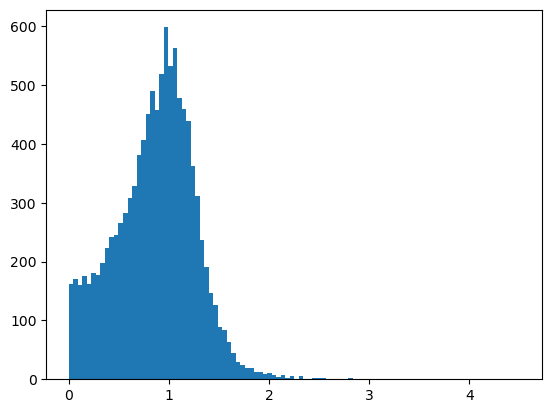

In [15]:
plt.hist(Z[Z > 0].cpu().detach().numpy(), 100);

In [17]:
thresh = 0.5

Z = F.relu(gnn(x_norm, adj_norm))
Z_pred = Z.cpu().detach().numpy() > thresh
model_saver.restore()
print(f'Final nmi = {get_nmi(thresh):.3f}')

Final nmi = 0.696


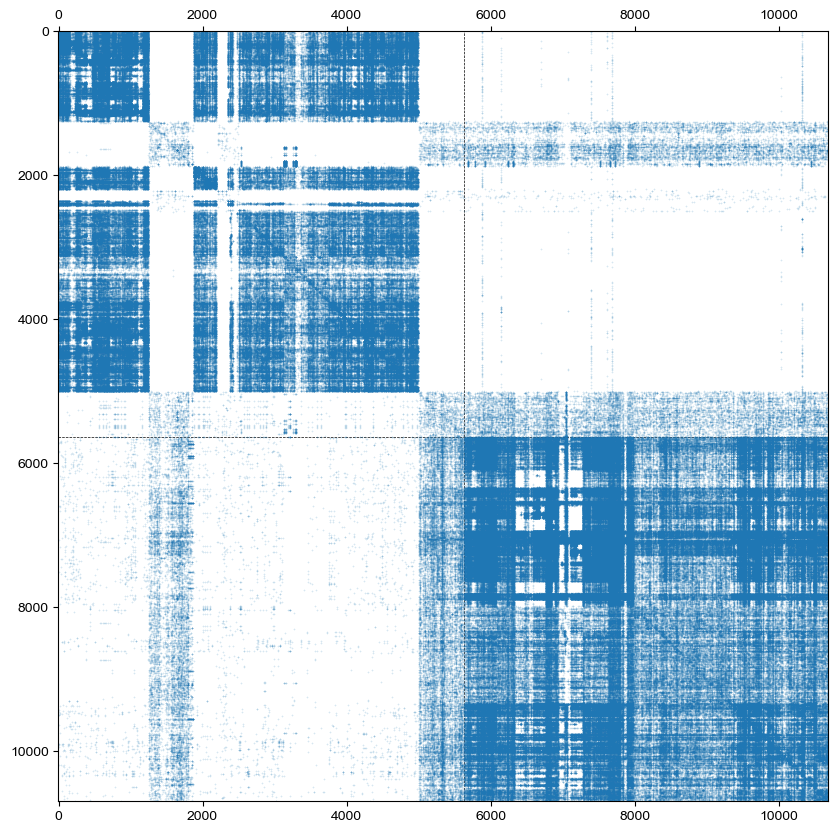

In [18]:
plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
nocd.utils.plot_sparse_clustered_adjacency(A, K, z, o, markersize=0.05)

In [19]:
# Sizes of detected communities
print(Z_pred.sum(0))

[3882 5108]


In [20]:
metrics = nocd.metrics.evaluate_unsupervised(Z_gt, A)
print(f"Ground truth communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

c:\Users\ACT\Desktop\overlapping-community-detection\nocd\metrics\unsupervised.py:29: RuntimeWarning: overflow encountered in scalar multiply
  possible = (n - 2) * (n - 1) * n / 6


Ground truth communities:
 - coverage    = 0.9962
 - conductance = 0.0040
 - density     = 2.517e-02
 - clust_coef  = 0.000e+00


In [21]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Predicted communities:
 - coverage    = 0.9363
 - conductance = 0.0311
 - density     = 3.327e-02
 - clust_coef  = 0.000e+00


In [22]:
Z_gt

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [1]:
Z_pred

NameError: name 'Z_pred' is not defined

In [25]:
def get_comlist(community_matrix):
    transposed_matrix = np.transpose(community_matrix)

    # Initialize an empty list to store tuples (community_id, nodes_list)
    community_nodes_list = []

    # Iterate through rows (communities)
    for community_id, community_row in enumerate(transposed_matrix):
        # Find nodes (columns) where the value is 1
        community_nodes = np.where(community_row == 1)[0].tolist()
        
        # Append a tuple to the list containing community ID and nodes list
        community_nodes_list.append(community_nodes)
    
    return community_nodes_list

In [26]:
from cdlib import NodeClustering
from cdlib import evaluation

coms1=get_comlist(Z_gt)
coms2=get_comlist(Z_pred)

communities1=NodeClustering(coms1,G)
communities2=NodeClustering(coms2,G)

onmi=evaluation.overlapping_normalized_mutual_information_LFK(communities1,communities2)
print(onmi)

MatchingResult(score=0.6476434010383642, std=None)
